In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

Data types in 'indu' dataframe:
Time     datetime64[ns]
Value             int64
dtype: object

Data types in 'cons' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object

Data types in 'gdp' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object


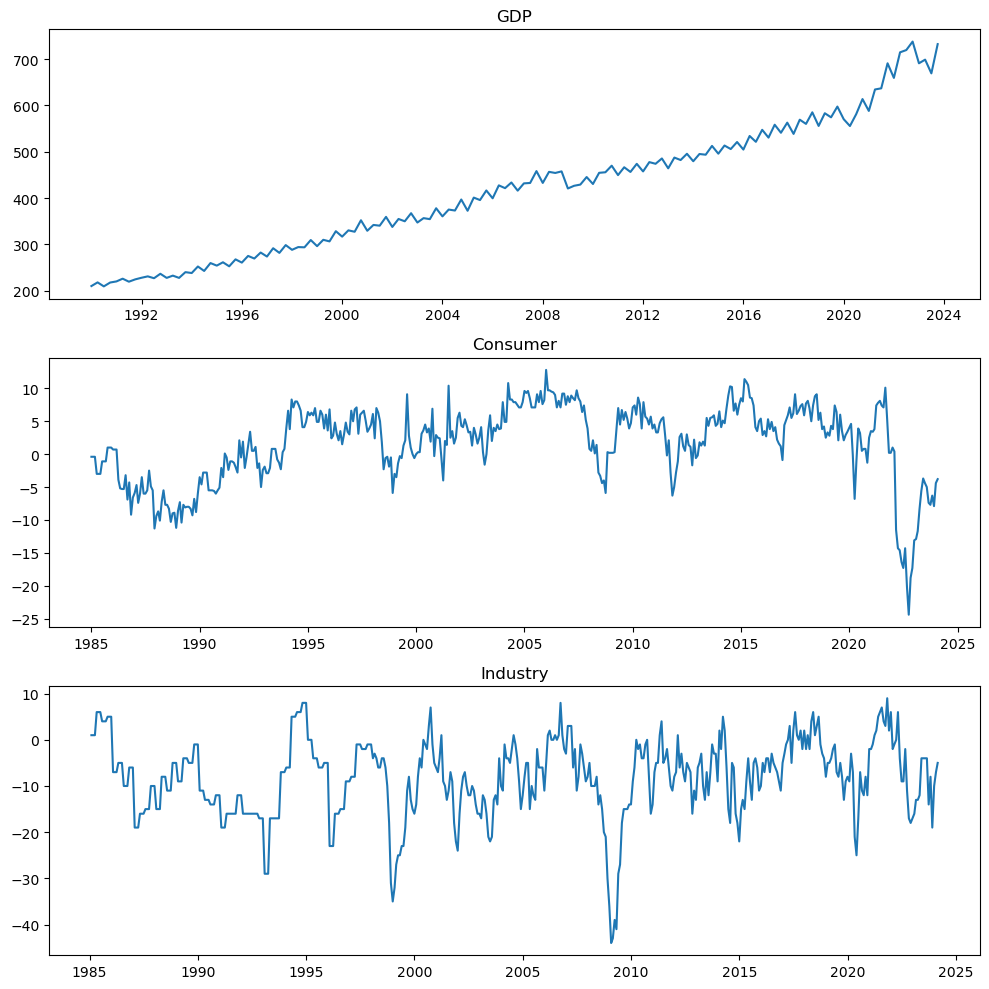

Value           float64
Time     datetime64[ns]
dtype: object
Value           float64
Time     datetime64[ns]
dtype: object


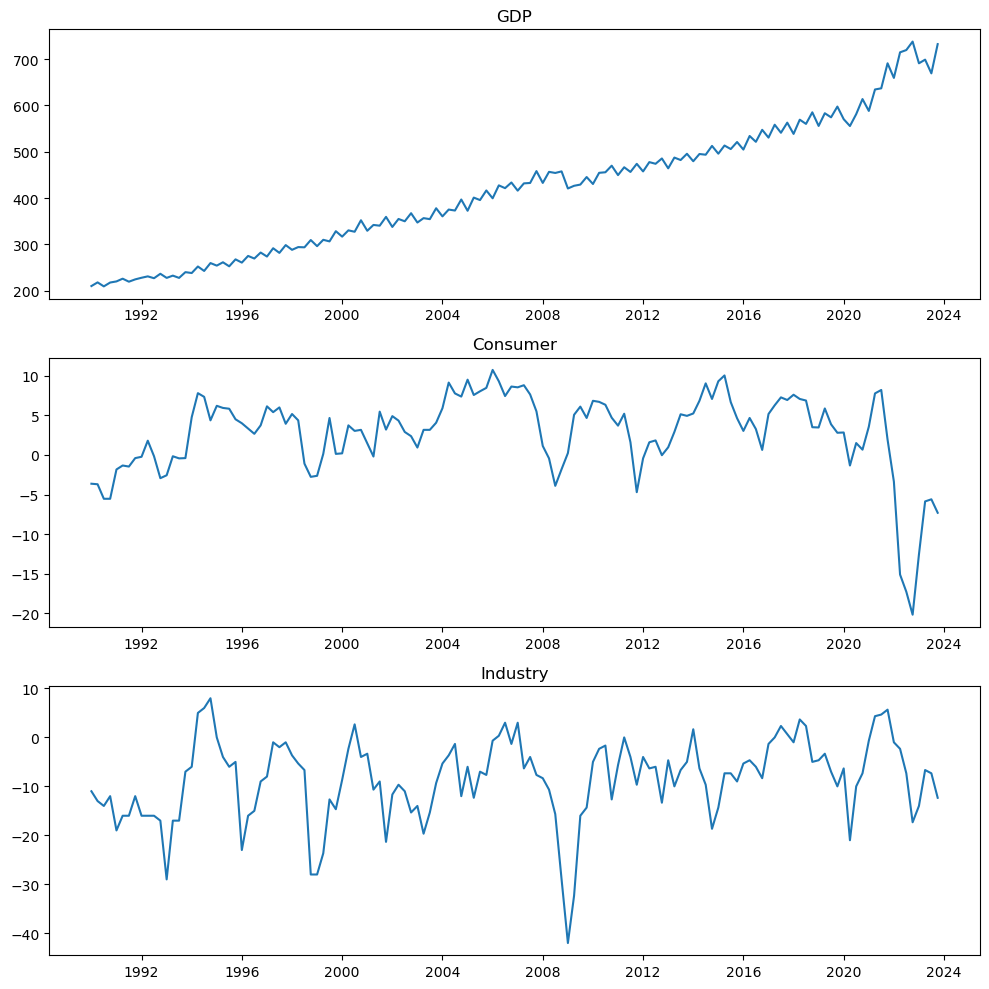

In [2]:
# Run the stored data from the Data_Preparation.ipynb
%run ..//Data_Preparation.ipynb

In [3]:
#Using the period 1990-2020 for training and 2021-2023 for testing
indu_train = indu[(indu['Time'] >= '1990-01-01') & (indu['Time'] < '2021-01-01')]
cons_train = cons[(cons['Time'] >= '1990-01-01') & (cons['Time'] < '2021-01-01')]
gdp_train = gdp[(gdp['Time'] >= '1990-01-01') & (gdp['Time'] < '2021-01-01')]

indu_test = indu[(indu['Time'] >= '2021-01-01') & (indu['Time'] < '2024-01-01')]
cons_test = cons[(cons['Time'] >= '2021-01-01') & (cons['Time'] < '2024-01-01')]
gdp_test = gdp[(gdp['Time'] >= '2021-01-01') & (gdp['Time'] < '2024-01-01')]

In [4]:
from statsmodels.tsa.arima.model import ARIMA
import itertools

#Resetting the index
gdp_train.reset_index(drop=True, inplace=True)
indu_train.reset_index(drop=True, inplace=True)
cons_train.reset_index(drop=True, inplace=True)

# Combine the explanatory variables into a single DataFrame
exog = pd.concat([indu_train['Value'].dropna() , cons_train['Value'].dropna()], axis=1)
exog.columns = ['Value_indu', 'Value_cons']

# Define the range of values for p, d, and q
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

# Create a list of all possible combinations of p, d, and q
param_combinations = list(itertools.product(p_values, d_values, q_values))

#Define the range of values for P, D, and Q
P_values = range(0, 3)
D_values = range(0, 3)
Q_values = range(0, 3)
m_values = range(0,4)

# Create a list of all possible combinations of P, D, and Q
seasonal_param_combinations = list(itertools.product(P_values, D_values, Q_values, m_values))


# Initialize variables to store the best model and its AIC value
best_model = None
best_aic = float('inf')

# Iterate over all combinations of p, d, and q
try:
    # Initialize variables to store the best model and its AIC value
    best_model = None
    best_aic = float('inf')

    # Iterate over all combinations of p, d, and q
    for params in param_combinations:
        for seasonal_params in seasonal_param_combinations:
            try:
                # Create the ARIMA model with the current parameters
                model = ARIMA(gdp_train['Value'].dropna(), order=params, exog=exog, seasonal_order=seasonal_params)

                # Fit the model
                model_fit = model.fit()

                # Get the AIC value of the model
                aic = model_fit.aic

                # Check if the current model has a lower AIC value than the best model so far
                if aic < best_aic:
                    best_model = model_fit
                    best_aic = aic
            except:
                continue
except:
    pass

# Print the summary of the best model
print(best_model.summary())

                                    SARIMAX Results                                    
Dep. Variable:                           Value   No. Observations:                  124
Model:             ARIMA(0, 1, 1)x(2, 2, 1, 3)   Log Likelihood                   0.000
Date:                         Mon, 18 Mar 2024   AIC                             14.000
Time:                                 15:01:56   BIC                             33.335
Sample:                                      0   HQIC                            21.850
                                         - 124                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Value_indu    87.7053      9.751      8.994      0.000      68.593     106.818
Value_cons   120.9029     13.442      8.994      0.000     

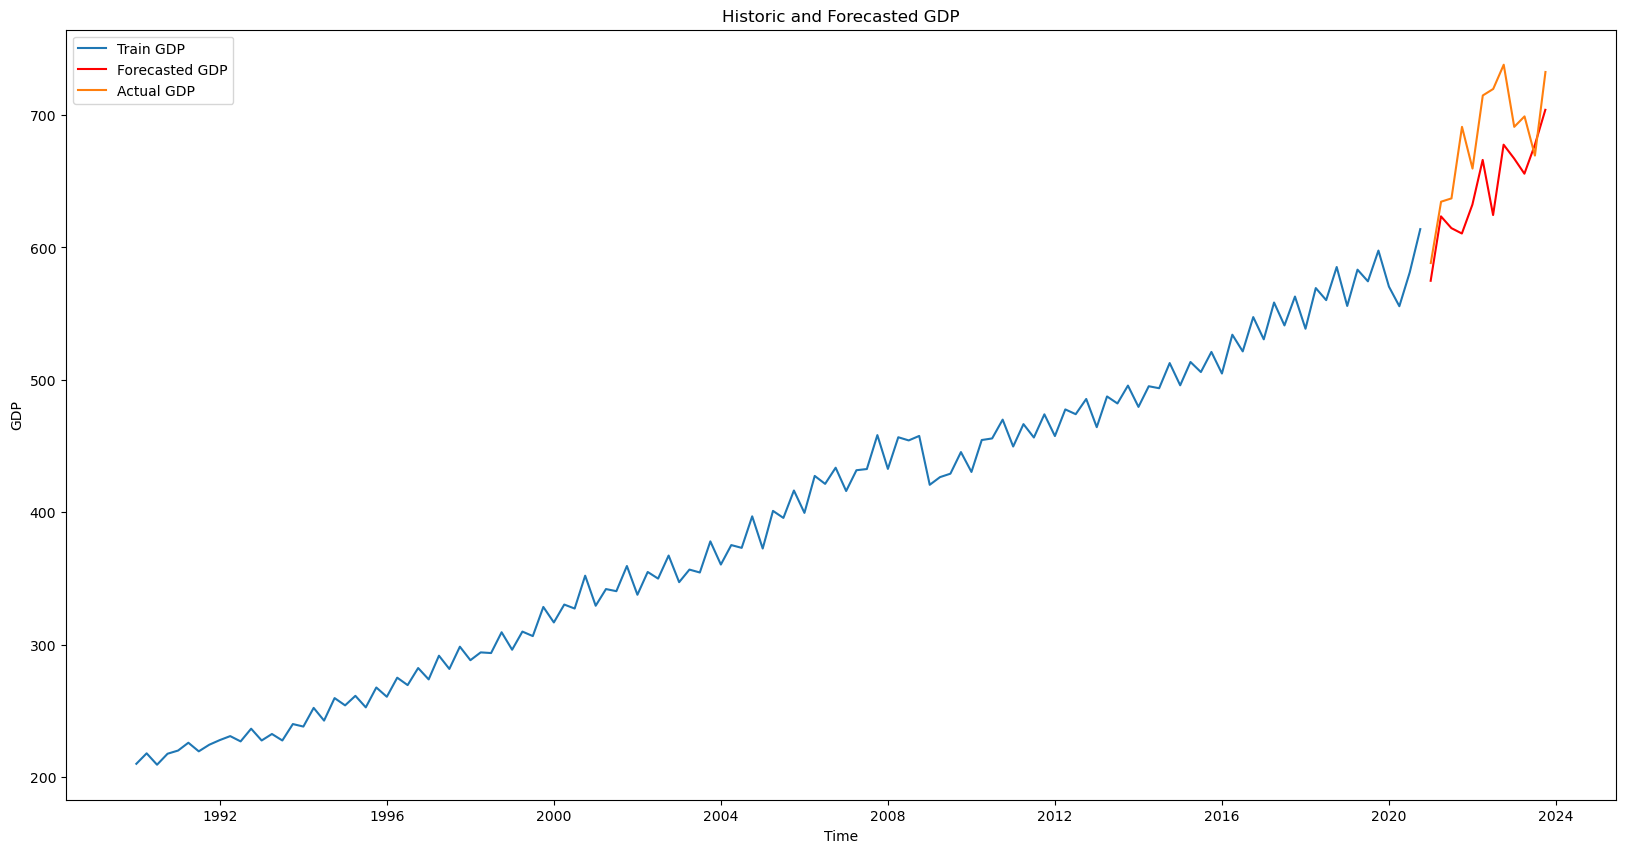

In [5]:
# Forecast 12 quarters ahead based on test indu and cons
fut_exog = pd.concat([indu_test['Value'].dropna(), cons_test['Value'].dropna()], axis=1)
fut_exog.columns = ['Value_indu', 'Value_cons']

forecast = model_fit.get_forecast(steps=12, exog=fut_exog.iloc[-12:])

# Get the forecasted values
forecast_values = forecast.predicted_mean

# Define the forecast dates
forecast_dates = pd.date_range(start=gdp_train['Time'].iloc[-1], periods=12, freq='QE')

# Plotting the forecasted values
# Plotting historic GDP and forecasted GDP
plt.figure(figsize=(20,10))
plt.plot(gdp_train['Time'], gdp_train['Value'], label='Train GDP')
plt.plot(forecast_dates, forecast_values, color='red', label='Forecasted GDP')
plt.plot(gdp_test['Time'], gdp_test['Value'], label='Actual GDP')

# Set the title and labels
plt.title('Historic and Forecasted GDP')
plt.xlabel('Time')
plt.ylabel('GDP')

# Add a legend
plt.legend()

# Display the plot
plt.show()

In [6]:
from statsmodels.tools.eval_measures import rmse
#Comparing the forecasted values with the actual values trough RMSE
# Calculate the RMSE
rmse_value = rmse(gdp_test['Value'], forecast_values)

# Print the RMSE
print("The RMSE is", rmse_value)

#The RMSE is 46.9, which is a good value for the forecasted GDP.

The RMSE is 46.91479172759626
